**Potato Disease Prediction Using ResNet-101 and RMSprop Optimizer**

In [1]:
import kagglehub

path = kagglehub.dataset_download("aarishasifkhan/plantvillage-potato-disease-dataset")
print("✅ Dataset downloaded to:", path)


✅ Dataset downloaded to: /kaggle/input/plantvillage-potato-disease-dataset


In [2]:
import os
print(os.listdir(path))


['PlantVillage']


In [3]:
base_path = os.path.join(path, "PlantVillage")


In [4]:
print(os.listdir(base_path))


['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


In [5]:
categories = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

In [6]:
import pandas as pd

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})
df.head()


,image_path,label
0,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
1,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
2,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
3,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight
4,/kaggle/input/plantvillage-potato-disease-data...,Potato___Early_blight


In [7]:
df.tail()

,image_path,label
2147,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
2148,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
2149,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
2150,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy
2151,/kaggle/input/plantvillage-potato-disease-data...,Potato___healthy


In [8]:
df.shape

(2152, 2)

In [9]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.isnull().sum()

,0
image_path,0
label,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2152 non-null   object
 1   label       2152 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


In [13]:
df['label'].unique()

array(['Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy'], dtype=object)

In [14]:
df['label'].value_counts()

,count
label,
Potato___Early_blight,1000
Potato___Late_blight,1000
Potato___healthy,152


/tmp/ipython-input-15-3248606741.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


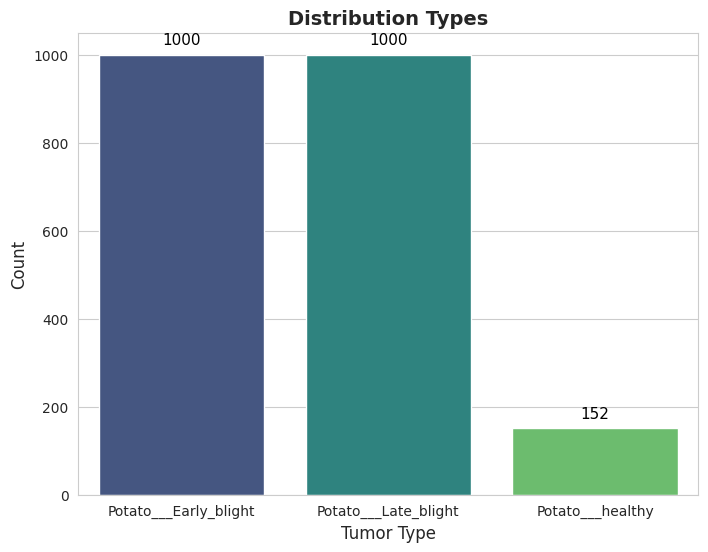

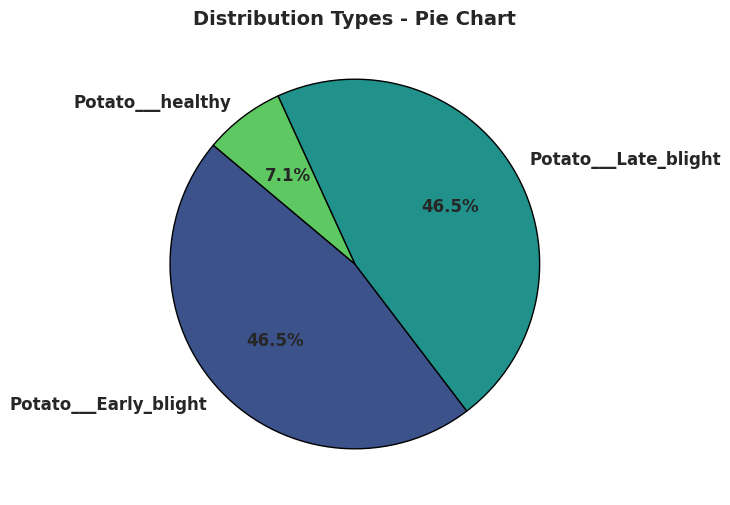

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution Types", fontsize=14, fontweight="bold")
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/ 2.,p.get_height()), ha='center', va='bottom', fontsize=11, color='black', xytext=(0,5), textcoords='offset points')
plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize = (8,6))
colors = sns.color_palette('viridis', len(label_counts))

ax.pie(label_counts,labels=label_counts.index, autopct = '%1.1f%%', startangle = 140, colors = colors, textprops ={'fontsize':12,'weight': 'bold'}, wedgeprops={'edgecolor':'black', 'linewidth': 1})

ax.set_title("Distribution Types - Pie Chart", fontsize=14, fontweight = 'bold')

plt.show()

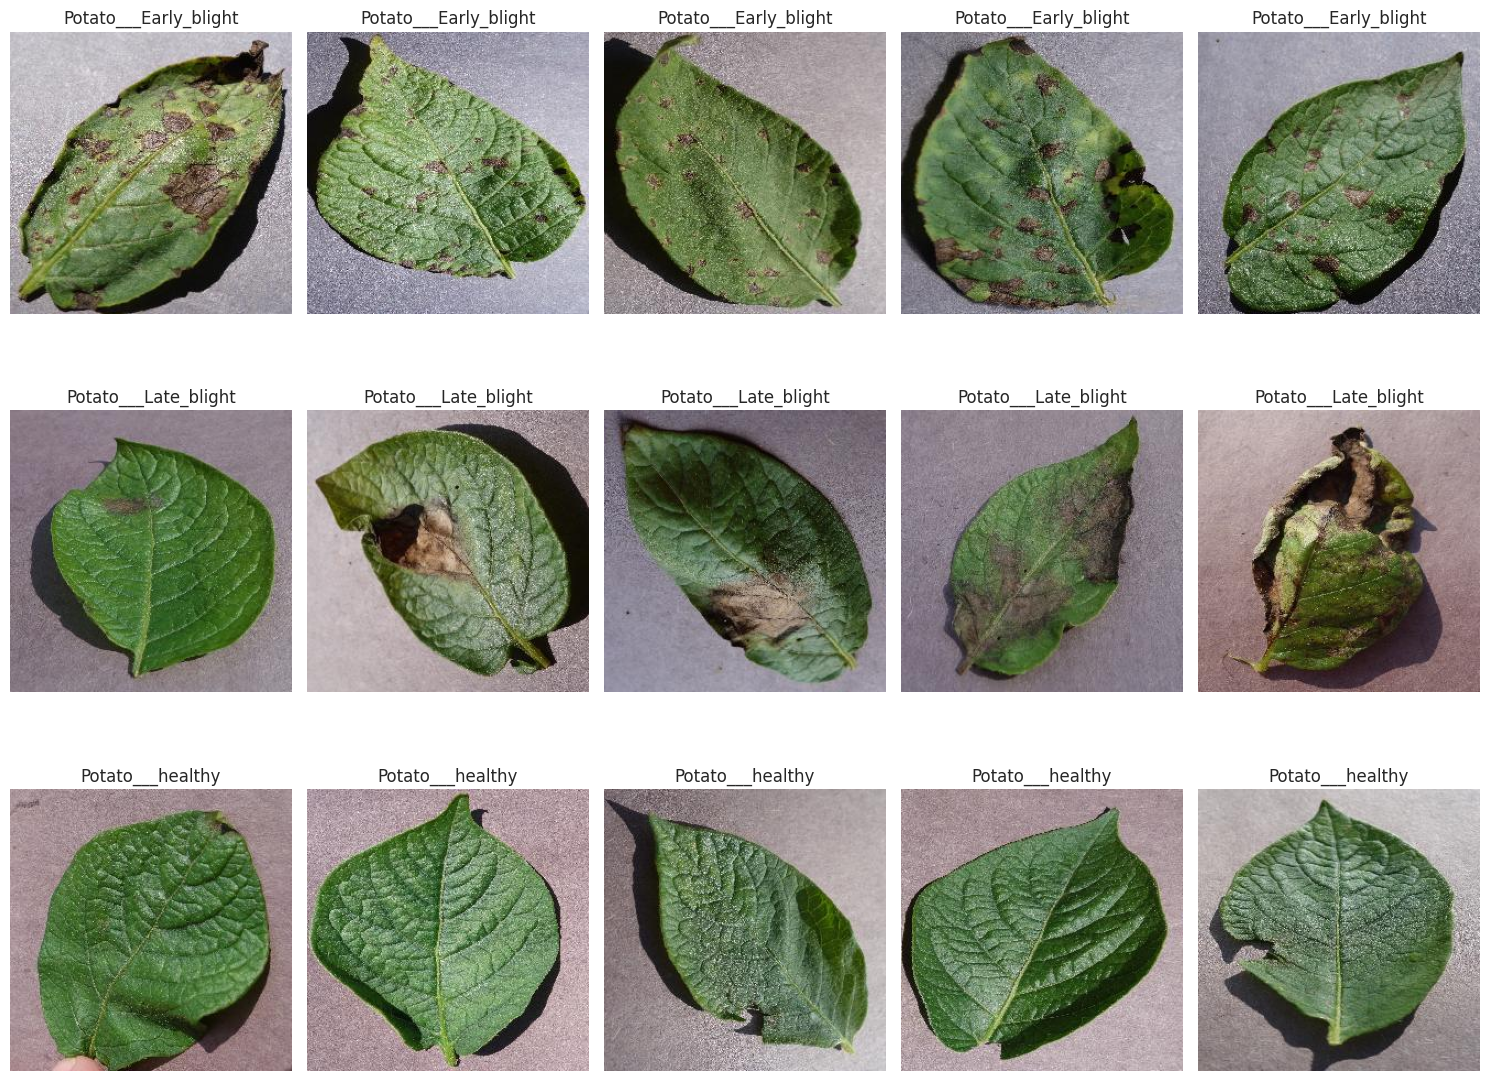

In [16]:
import cv2

num_images = 5

plt.figure(figsize=(15,12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images,  i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]

from sklearn.utils import resample
max_count = df['category_encoded'].value_counts().max()

dfs = []
for category in df['category_encoded'].unique():
    class_subset = df[df['category_encoded'] == category]
    class_unsampled = resample(class_subset, replace=True, n_samples = max_count, random_state = 42)
    dfs.append(class_unsampled)

df_balanced = pd.concat(dfs).sample(frac = 1, random_state = 42).reset_index(drop = True)
df_balanced['category_encoded'].value_counts()

,count
category_encoded,
1,1000
0,1000
2,1000


In [18]:
df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [19]:
import numpy as np
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")
print("check")

check


In [20]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size = 0.8,
    shuffle = True,
    random_state = 42,
    stratify = df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size = 0.5,
    shuffle = True,
    random_state = 42,
    stratify = temp_df_new['category_encoded']
)

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rescale = 1./255
)

ts_gen = ImageDataGenerator(rescale = 1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

Found 2400 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.


In [21]:
import tensorflow as tf
print("Number of GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Number of GPUs Available: 1


In [22]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is set for TensorFlow")
  except RuntimeError as e:
        print(e)

GPU is set for TensorFlow


In [23]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

# Number of classes
num_classes = len(train_df_new['category_encoded'].unique())

# Input shape
img_shape = (224, 224, 3)

# Load ResNet152 base
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=img_shape)

# Unfreeze last 30 layers of ResNet152 for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add custom head on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

optimizer = RMSprop(learning_rate=1e-5, weight_decay=1e-4)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,183,491 (164.73 MB)

 Trainable params: 14,975,491 (57.13 MB)

 Non-trainable params: 28,208,000 (107.60 MB)

In [24]:
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

start_time = time.time()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)


end_time = time.time()
training_time = end_time - start_time

# ✅ Print training time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 190ms/step - accuracy: 0.6564 - loss: 0.8011 - val_accuracy: 0.3367 - val_loss: 1.1130 - learning_rate: 1.0000e-05
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.8667 - loss: 0.3887 - val_accuracy: 0.6700 - val_loss: 0.6587 - learning_rate: 1.0000e-05
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9216 - loss: 0.2359 - val_accuracy: 0.9200 - val_loss: 0.2836 - learning_rate: 1.0000e-05
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.9408 - loss: 0.1872 - val_accuracy: 0.9367 - val_loss: 0.1508 - learning_rate: 1.0000e-05
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9693 - loss: 0.1101 - val_accuracy: 0.9633 - val_loss: 0.1154 - learning_rate: 1.0000e-05
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.9834 - loss: 0.0759 - val_accuracy: 0.9633 - val_loss: 0.0871 - learning_rate: 1.0000e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 11

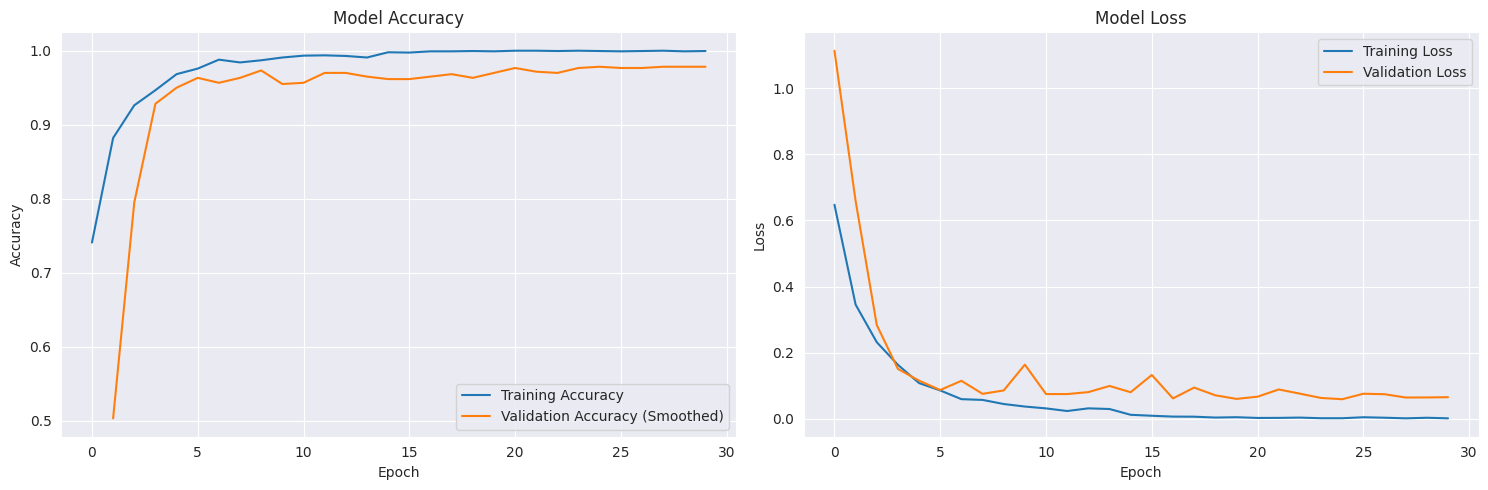

In [25]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['accuracy'], label='Training Accuracy')
  val_smooth = pd.Series(history.history['val_accuracy']).rolling(window=2).mean()
  ax1.plot(val_smooth, label='Validation Accuracy (Smoothed)')
  ax1.set_title('Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)
  ax2.plot(history.history['loss'], label='Training Loss')
  ax2.plot(history.history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)
  plt.tight_layout()
  plt.show()
plot_training_history(history)

In [26]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9748 - loss: 0.1441
Test Accuracy: 0.9733, Test Loss: 0.1771


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
test_gen_new.reset()
y_pred = model.predict(test_gen_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_new.classes

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step


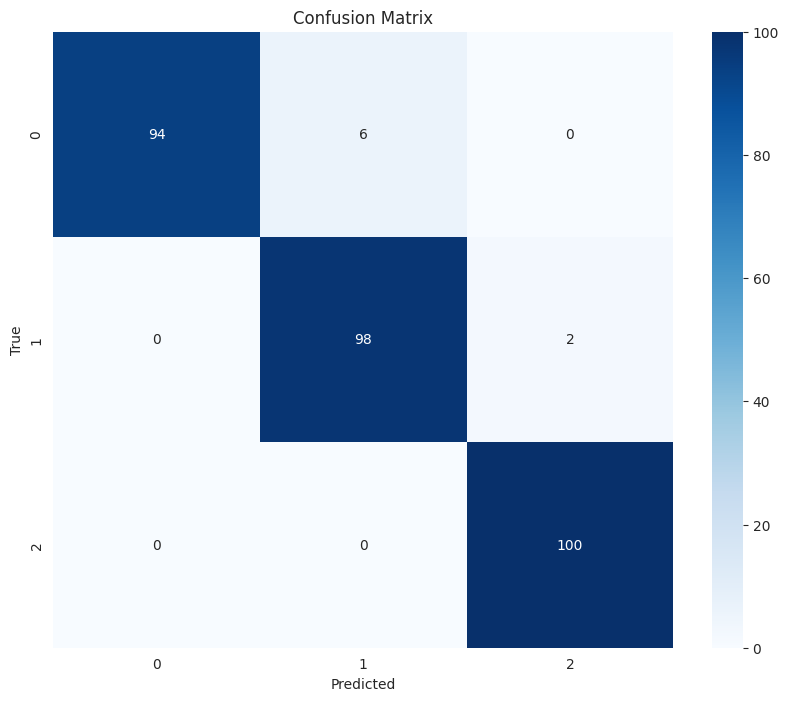

In [28]:
class_names = list(test_gen_new.class_indices.keys())
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       100
           1       0.94      0.98      0.96       100
           2       0.98      1.00      0.99       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

